In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import resize
#---------------------------------------
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2024-08-10 21:54:27.511488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 21:54:27.511609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 21:54:27.641803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [5]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [6]:
# Define paths
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Image dimensions
img_height, img_width = 224, 224

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
# Only rescaling for testing
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess the validation data
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load and preprocess the testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Verify the class indices
print(train_generator.class_indices)
print(test_generator.class_indices)

Found 5712 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


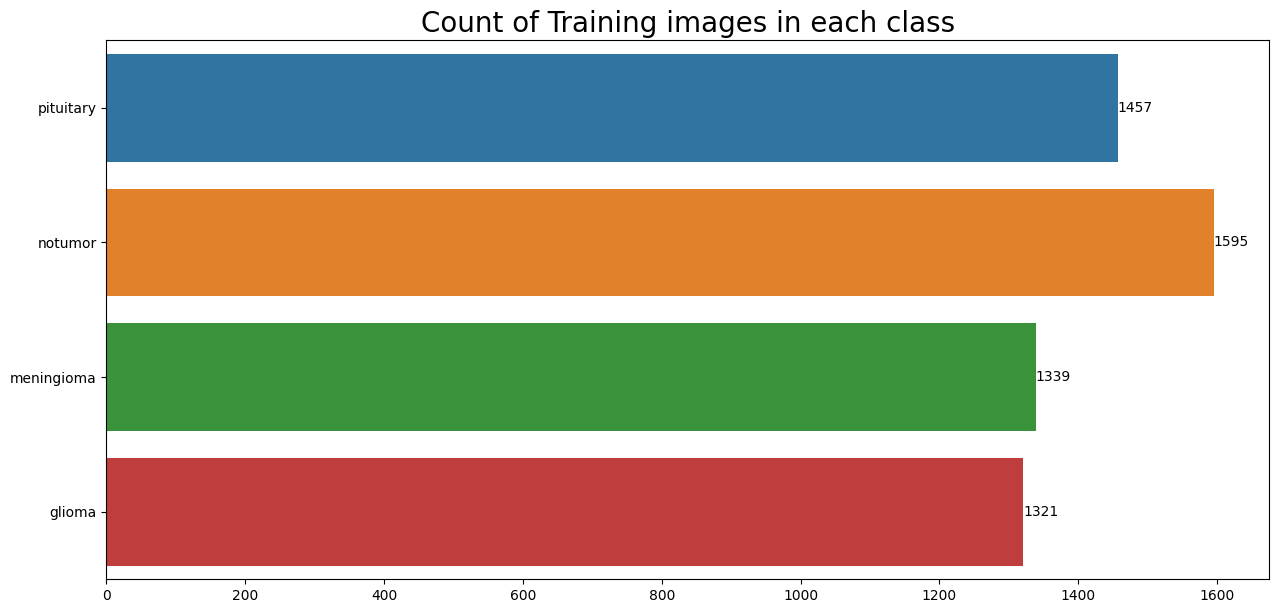

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of Training images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

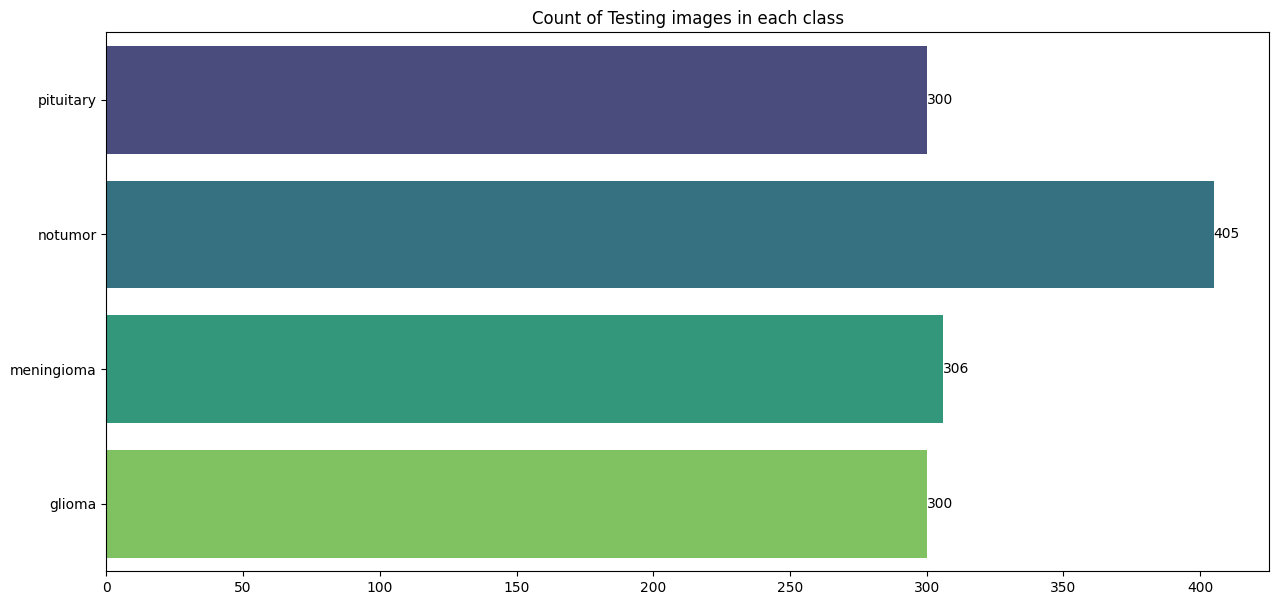

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of Testing images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [11]:
# Define paths
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Image dimensions
img_height, img_width = 224, 224

# Function to load and resize images
def load_and_resize_images(directory, target_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = load_img(img_path)
            image = img_to_array(image)
            image = resize(image, target_size)
            images.append(image.numpy()) 
            labels.append(class_name)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

# Load and resize training data
train_images, train_labels, class_names = load_and_resize_images(train_dir)
test_images, test_labels, _ = load_and_resize_images(test_dir)

# Display basic dataset information
print(f'Number of training images: {len(train_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Classes: {class_names}')

Number of training images: 5712
Number of testing images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
# Analyze image dimensions
def analyze_image_dimensions(images):
    dimensions = [img.shape for img in images]
    dimensions = np.array(dimensions)
    unique_dimensions, counts = np.unique(dimensions, axis=0, return_counts=True)
    for dim, count in zip(unique_dimensions, counts):
        print(f'Dimension: {dim}, Count: {count}')

print('Training Image Dimensions:')
analyze_image_dimensions(train_images)
print('Testing Image Dimensions:')
analyze_image_dimensions(test_images)

Training Image Dimensions:
Dimension: [224 224   3], Count: 5712
Testing Image Dimensions:
Dimension: [224 224   3], Count: 1311


In [13]:
# Compute basic statistics
def compute_statistics(images):
    pixel_values = images.ravel()
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    min_val = np.min(pixel_values)
    max_val = np.max(pixel_values)
    return mean, std, min_val, max_val

train_mean, train_std, train_min, train_max = compute_statistics(train_images)
test_mean, test_std, test_min, test_max = compute_statistics(test_images)

print(f'Training Data - Mean: {train_mean}, Std: {train_std}, Min: {train_min}, Max: {train_max}')
print(f'Testing Data - Mean: {test_mean}, Std: {test_std}, Min: {test_min}, Max: {test_max}')

Training Data - Mean: 47.285579681396484, Std: 51.528846740722656, Min: 0.0, Max: 255.0
Testing Data - Mean: 49.151268005371094, Std: 53.712154388427734, Min: 0.0, Max: 255.0


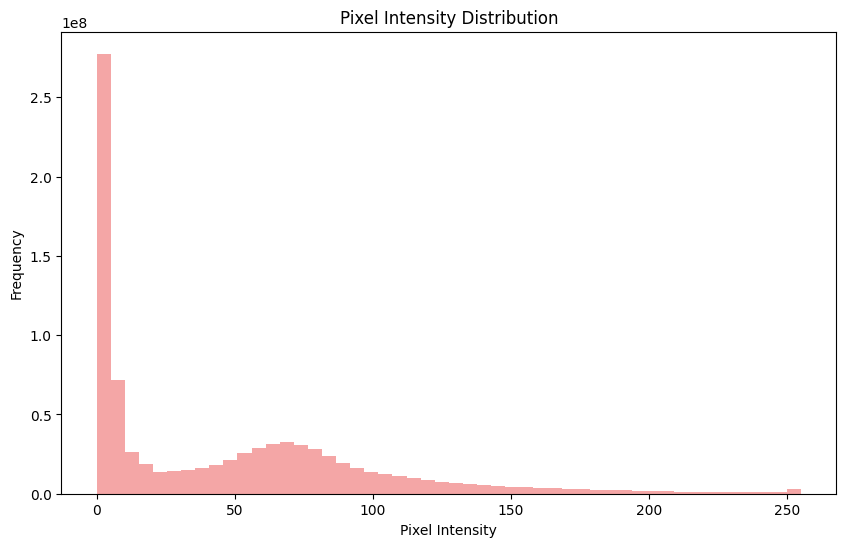

In [14]:
def plot_pixel_intensity_distribution(images):
    flattened_images = images.reshape(-1, images.shape[-1])
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_images.flatten(), bins=50, color='lightcoral', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_distribution(train_images)

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tempfile
import shutil

# Load and preprocess training data
train_images = []
train_labels = []
class_names = sorted(os.listdir(train_dir))
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        train_images.append(image)
        train_labels.append(label_map[class_name])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load and preprocess testing data
test_images = []
test_labels = []

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        test_images.append(image)
        test_labels.append(label_map[class_name])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = test_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

In [16]:
# Create a function to create a model with transfer learning and hyperparameter tuning
def build_model(hp, base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', min_value=512, max_value=2048, step=512), activation='relu')(x)
    x = Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1))(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# List of pre-trained models to use
pretrained_models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
}

fine_tuned_models = {}

# Use a temporary directory for Keras Tuner
temp_dir = tempfile.mkdtemp()

try:
    for model_name, base_model in pretrained_models.items():
        print(f"Tuning model: {model_name}")

        # Freeze the layers of the base model
        for layer in base_model.layers:
            layer.trainable = False

        # Hypermodel function for Keras Tuner
        def hypermodel(hp):
            return build_model(hp, base_model)

        tuner = kt.RandomSearch(
            hypermodel,
            objective='val_accuracy',
            max_trials=1,
            executions_per_trial=2,
            directory=temp_dir,  # Use temporary directory
            project_name=f'{model_name}_tuning'
        )

        tuner.search_space_summary()

        # Perform hyperparameter search
        tuner.search(train_generator,
                     epochs=1,
                     validation_data=val_generator,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

        # Get the optimal hyperparameters and best model
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hp)

        # Unfreeze some of the top layers for fine-tuning
        for layer in best_model.layers[-4:]:
            layer.trainable = True

        # Compile the model with a lower learning rate
        best_model.compile(optimizer=Adam(learning_rate=best_hp.get('learning_rate')), 
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model with fine-tuning
        best_model.fit(
            train_generator,
            epochs=1,
            validation_data=val_generator,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
            ]
        )

        # Evaluate the model on the test set
        test_loss, test_acc = best_model.evaluate(test_generator)
        print(f"Fine-tuned {model_name} Test Accuracy: {test_acc:.4f}")

        fine_tuned_models[model_name] = best_model
finally:
    # Clean up temporary directory
    shutil.rmtree(temp_dir)

Trial 1 Complete [00h 04m 14s]
val_accuracy: 0.27909010648727417

Best val_accuracy So Far: 0.27909010648727417
Total elapsed time: 00h 04m 14s
  2/143 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.2344 - loss: 1.8880    

W0000 00:00:1723327886.114236      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/143 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.2482 - loss: 2.0192

W0000 00:00:1723327917.440268      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.2544 - loss: 1.6410

W0000 00:00:1723327960.464706      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723327965.029583      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 557ms/step - accuracy: 0.2544 - loss: 1.6398 - val_accuracy: 0.2791 - val_loss: 1.3845 - learning_rate: 0.0100
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.1600 - loss: 1.4071
Fine-tuned EfficientNetB0 Test Accuracy: 0.3089


W0000 00:00:1723327977.691226      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
import pickle

# Save the fine-tuned models dictionary to a pickle file
with open('fine_tuned_models.pkl', 'wb') as f:
    pickle.dump(fine_tuned_models, f)

print("Fine-tuned models saved as 'fine_tuned_models.pkl'")

Fine-tuned models saved as 'fine_tuned_models.pkl'


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Track true labels separately
true_classes = test_labels

# Get the names of the classes
class_labels = class_names

# Evaluate each fine-tuned model individually and print the classification report
for model_name, model in fine_tuned_models.items():
    # Use the model to predict the labels for the test data
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    print(f"{model_name} Confusion Matrix:")
    print(cm)

    # Generate and print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"{model_name} Classification Report:")
    print(report)

    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

 2/41 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step 

W0000 00:00:1723327982.345000      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step


W0000 00:00:1723327987.515400      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


VGG16 Confusion Matrix:
[[247  32  10  11]
 [ 72  99  57  78]
 [ 18   5 378   4]
 [ 11   0  11 278]]
VGG16 Classification Report:
              precision    recall  f1-score   support

      glioma       0.71      0.82      0.76       300
  meningioma       0.73      0.32      0.45       306
     notumor       0.83      0.93      0.88       405
   pituitary       0.75      0.93      0.83       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.73      1311
weighted avg       0.76      0.76      0.74      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7121 - loss: 0.7751
VGG16 Test Accuracy: 0.7643
 4/41 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step

W0000 00:00:1723328003.157159      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step


W0000 00:00:1723328011.954231      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


InceptionV3 Confusion Matrix:
[[245  23  15  17]
 [ 73  92  67  74]
 [ 13   8 378   6]
 [  8   6   7 279]]
InceptionV3 Classification Report:
              precision    recall  f1-score   support

      glioma       0.72      0.82      0.77       300
  meningioma       0.71      0.30      0.42       306
     notumor       0.81      0.93      0.87       405
   pituitary       0.74      0.93      0.83       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.72      1311
weighted avg       0.75      0.76      0.73      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7054 - loss: 0.7171
InceptionV3 Test Accuracy: 0.7582
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

W0000 00:00:1723328025.496368      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step


W0000 00:00:1723328033.259056      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EfficientNetB0 Confusion Matrix:
[[  0   0 300   0]
 [  0   0 306   0]
 [  0   0 405   0]
 [  0   0 300   0]]
EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1600 - loss: 1.4071
EfficientNetB0 Test Accuracy: 0.3089


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate each fine-tuned model individually and print the classification report and plot confusion matrix
for model_name, model in fine_tuned_models.items():
    print(f"Evaluating model: {model_name}")
    
    try:
        # Use the model to predict the labels for the test data
        predictions = model.predict(test_generator)
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the true labels (ensure your test_generator has shuffle=False)
        true_classes = test_generator.labels

        # Get the names of the classes
        class_labels = list(test_generator.class_indices.keys())

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"{model_name} Confusion Matrix:")
        print(cm)

        # Plot confusion matrix
        plot_confusion_matrix(cm, class_labels, model_name)

        # Generate and print classification report
        report = classification_report(true_classes, predicted_classes, target_names=class_labels)
        print(f"{model_name} Classification Report:")
        print(report)

        # Evaluate the model on the test data
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    
    except Exception as e:
        print(f"An error occurred while evaluating {model_name}: {e}")

Evaluating model: VGG16
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step 

W0000 00:00:1723328037.948214      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


W0000 00:00:1723328043.084830      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


An error occurred while evaluating VGG16: 'NumpyArrayIterator' object has no attribute 'labels'
Evaluating model: InceptionV3
 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

W0000 00:00:1723328049.909775      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step


W0000 00:00:1723328058.709091      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


An error occurred while evaluating InceptionV3: 'NumpyArrayIterator' object has no attribute 'labels'
Evaluating model: EfficientNetB0
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

W0000 00:00:1723328065.121650      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step
An error occurred while evaluating EfficientNetB0: 'NumpyArrayIterator' object has no attribute 'labels'


W0000 00:00:1723328072.928232      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/41 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step 

W0000 00:00:1723328089.490287      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step


W0000 00:00:1723328094.528169      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

W0000 00:00:1723328101.485342      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step


W0000 00:00:1723328109.710909      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

W0000 00:00:1723328115.467264      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step


W0000 00:00:1723328122.444180      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Ensemble Test Accuracy: 0.7719
Ensemble Confusion Matrix:
[[249  24  13  14]
 [ 63  87  60  96]
 [ 12   3 386   4]
 [  5   1   4 290]]
Ensemble Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.83      0.79       300
  meningioma       0.76      0.28      0.41       306
     notumor       0.83      0.95      0.89       405
   pituitary       0.72      0.97      0.82       300

    accuracy                           0.77      1311
   macro avg       0.77      0.76      0.73      1311
weighted avg       0.77      0.77      0.74      1311



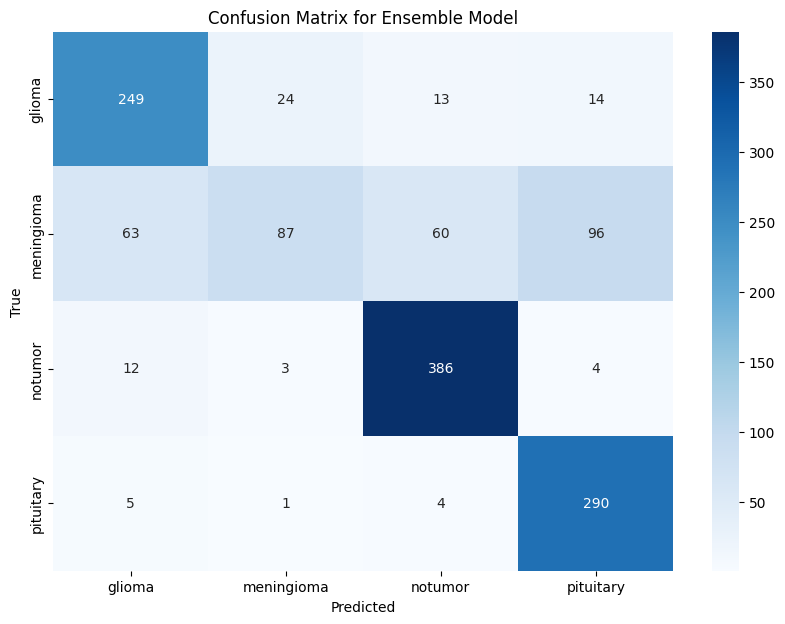

In [20]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load the fine-tuned models from the pickle file
with open('fine_tuned_models.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

# Function to create ensemble predictions
def create_ensemble(models, test_generator):
    preds = [model.predict(test_generator) for model in models]
    avg_preds = np.mean(preds, axis=0)
    return avg_preds

# Generate ensemble predictions
ensemble_preds = create_ensemble(loaded_models.values(), test_generator)

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(np.argmax(ensemble_preds, axis=1) == test_labels)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

# Generate confusion matrix and classification report for the ensemble
ensemble_predicted_classes = np.argmax(ensemble_preds, axis=1)
ensemble_cm = confusion_matrix(test_labels, ensemble_predicted_classes)
ensemble_report = classification_report(test_labels, ensemble_predicted_classes, target_names=class_names)

print("Ensemble Confusion Matrix:")
print(ensemble_cm)
print("Ensemble Classification Report:")
print(ensemble_report)

# Visualize the confusion matrix
plot_confusion_matrix(ensemble_cm, class_names, "Ensemble Model")

In [21]:
import shap
import numpy as np

# Load a single image from the test set and ensure it's in the correct format
sample_image = test_images[0:1]

# Ensure sample image has the correct shape (batch size, height, width, channels)
if len(sample_image.shape) == 3:
    sample_image = np.expand_dims(sample_image, axis=0)

# Function to explain the model's predictions using SHAP
def explain_model(model, sample_image, train_images):
    shap_values = None

    # Attempt to use DeepExplainer
    try:
        print("Trying SHAP DeepExplainer...")
        explainer = shap.DeepExplainer(model, train_images[:100])
        shap_values = explainer.shap_values(sample_image)
        print("SHAP DeepExplainer successful!")
    except Exception as e:
        print(f"SHAP DeepExplainer failed: {e}")

    # If DeepExplainer fails, try KernelExplainer
    if shap_values is None:
        try:
            print("Trying SHAP KernelExplainer...")
            # Flatten the image and adjust for KernelExplainer input
            sample_image_flat = sample_image.reshape((sample_image.shape[0], -1))
            train_images_flat = train_images[:100].reshape((100, -1))
            explainer = shap.KernelExplainer(model.predict, train_images_flat)
            shap_values = explainer.shap_values(sample_image_flat)
            print("SHAP KernelExplainer successful!")
        except Exception as e:
            print(f"SHAP KernelExplainer failed: {e}")

    # If SHAP explanations were successful, visualize them
    if shap_values is not None:
        shap.image_plot([shap_values], sample_image)
    else:
        print("Failed to generate SHAP explanations with both DeepExplainer and KernelExplainer.")

# Call the function to explain the model
explain_model(model, sample_image, train_images)

Trying SHAP DeepExplainer...
SHAP DeepExplainer failed: 'tuple' object has no attribute 'as_list'
Trying SHAP KernelExplainer...
Provided model function fails when applied to the provided data set.
SHAP KernelExplainer failed: as_list() is not defined on an unknown TensorShape.
Failed to generate SHAP explanations with both DeepExplainer and KernelExplainer.
